# Reuters Newswire Classification
*Charles Roberts, Kyle Rohde, Noah Trilling*

In [53]:
import os
import zipfile
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from keras.datasets import reuters
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional, SimpleRNN, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import keras_tuner as kt
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.losses import CategoricalFocalCrossentropy
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import ReduceLROnPlateau
import urllib
from sklearn.metrics import confusion_matrix
import pandas as pd

seed = 42
max_sequence_length = 300
vocabulary_size = 10000

## Exploratory Data Analysis
Load the newswire dataset, word index, and label names.

In [54]:
(x_full, y_full), (x_foo, y_foo) = reuters.load_data(test_split=0, seed=seed)
index_by_word = reuters.get_word_index(path="reuters_word_index.json")
word_by_offset_index = {index + 3: word for word, index in index_by_word.items()}
reuters_label_names = reuters.get_label_names()
label_names = [str(i) for i in range(46)]  # 46 total classes
y_full_label_names_decoded = [reuters_label_names[label] for label in y_full]
num_classes = len(label_names)
print(f"Total samples: {len(x_full)}")
print(f"Total classes: {num_classes}")
print(f"Total vocabulary: {len(index_by_word)}")
print(f"Longest Sequence: {max([len(x) for x in x_full])}")
print(f"Shortest Sequence: {min([len(x) for x in x_full])}")
print(f"Average Sequence Length: {np.mean([len(x) for x in x_full])}")
sorted_word_index = sorted(index_by_word.items(), key=lambda x: x[1])
print(f"Top 50 Words: {sorted_word_index[:50]}")
print(f"Bottom 50 Words: {sorted_word_index[-50:]}")
print(f"All Classes: {reuters_label_names}")
print(f"Sample x: {x_full[0]}")
print(f"Sample y: {y_full[0]}")
print(f"Sample x (decoded): {[word_by_offset_index.get(i, '?') for i in x_full[0]]}")
print(f"Sample y (decoded): {reuters_label_names[y_full[0]]}")

Total samples: 11228
Total classes: 46
Total vocabulary: 30979
Longest Sequence: 2376
Shortest Sequence: 2
Average Sequence Length: 145.96419665122906
Top 50 Words: [('the', 1), ('of', 2), ('to', 3), ('in', 4), ('said', 5), ('and', 6), ('a', 7), ('mln', 8), ('3', 9), ('for', 10), ('vs', 11), ('dlrs', 12), ('it', 13), ('reuter', 14), ('000', 15), ('1', 16), ('pct', 17), ('on', 18), ('from', 19), ('is', 20), ('that', 21), ('its', 22), ('cts', 23), ('by', 24), ('at', 25), ('year', 26), ('be', 27), ('with', 28), ('2', 29), ('will', 30), ('was', 31), ('billion', 32), ('he', 33), ('u', 34), ('s', 35), ('net', 36), ('has', 37), ('would', 38), ('an', 39), ('as', 40), ('5', 41), ('not', 42), ('loss', 43), ('4', 44), ('1986', 45), ('company', 46), ('which', 47), ('but', 48), ('this', 49), ('shr', 50)]
Bottom 50 Words: [('teishoku', 30930), ('bbd', 30931), ('grandmarais', 30932), ('enahnce', 30933), ('jerritt', 30934), ('wilq', 30935), ('cogeca', 30936), ('unflappable', 30937), ('cogeco', 30938),

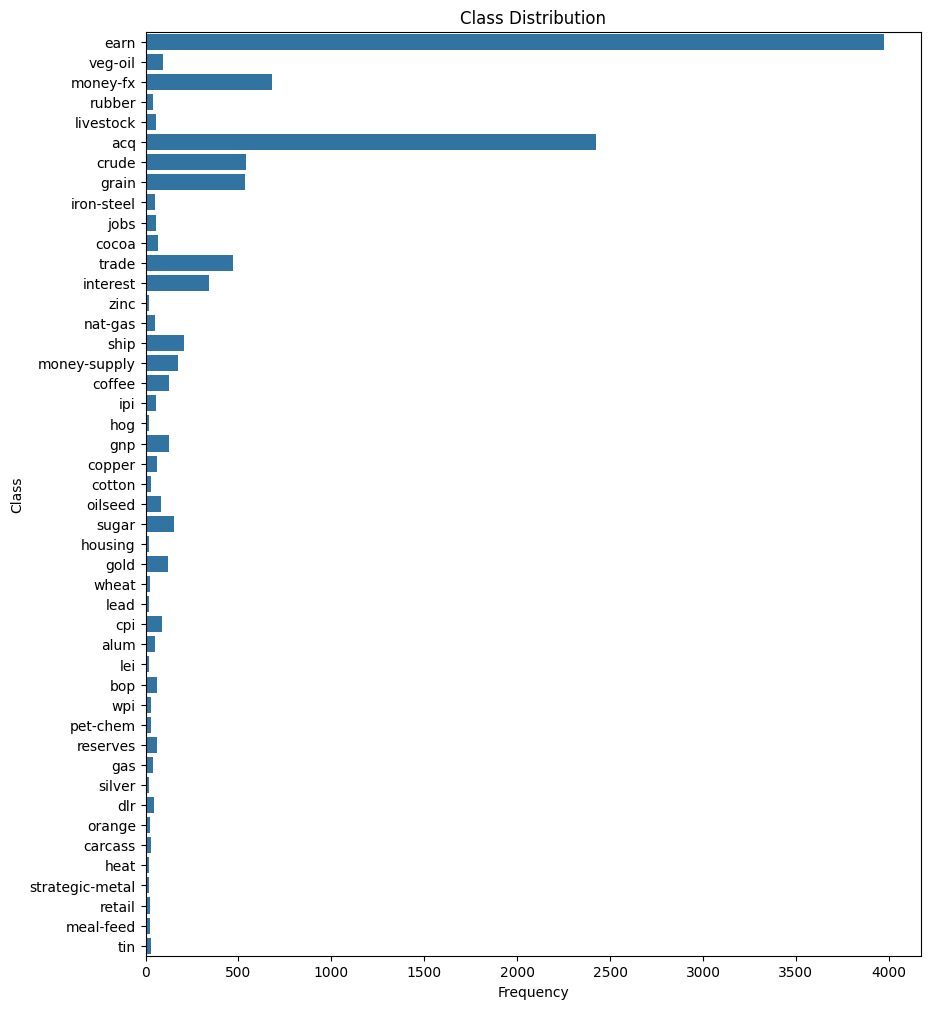

In [55]:
plt.figure(figsize=(10, 12))
sns.countplot(y_full_label_names_decoded)
plt.title("Class Distribution")
plt.xlabel("Frequency")
plt.ylabel("Class")
plt.show()

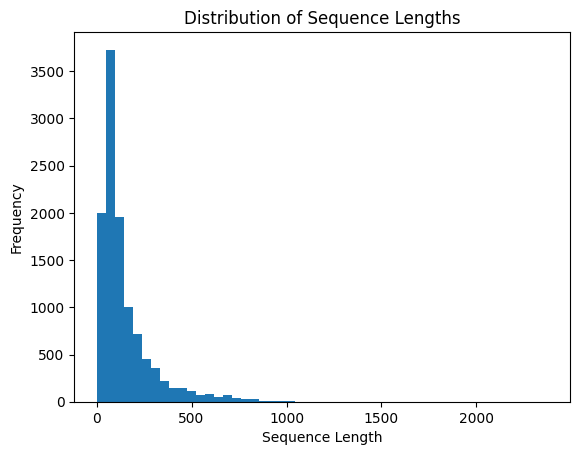

In [56]:
sequence_lengths = [len(seq) for seq in x_full]
plt.hist(sequence_lengths, bins=50)
plt.title("Distribution of Sequence Lengths")
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.show()

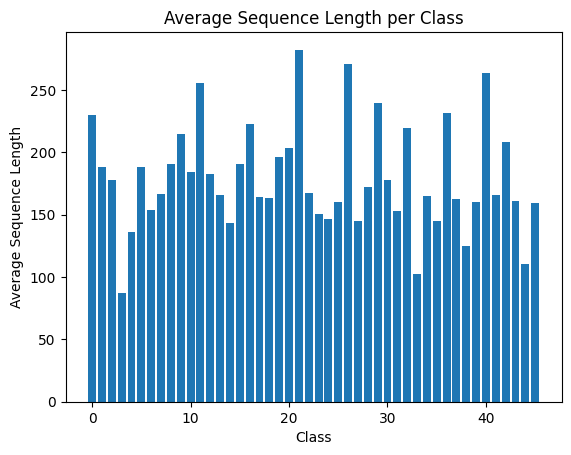

In [57]:
avg_lengths_per_class = [np.mean([len(x_full[i]) for i in range(len(y_full)) if y_full[i] == label]) for label in range(len(label_names))]
plt.bar(range(len(label_names)), avg_lengths_per_class)
plt.title("Average Sequence Length per Class")
plt.xlabel("Class")
plt.ylabel("Average Sequence Length")
plt.show()

## Data Preprocessing

In [58]:
(x_full, y_full), (x_foo, y_foo) = reuters.load_data(num_words=vocabulary_size, maxlen=max_sequence_length, test_split=0, seed=seed)
x_train, x_temp, y_train, y_temp = train_test_split(
    x_full, y_full, test_size=0.2, random_state=seed, stratify=y_full
)
x_test, x_val, y_test, y_val = train_test_split(
    x_temp, y_temp, test_size=0.5, random_state=seed, stratify=y_temp
)

y_train_cat = to_categorical(y_train)
y_val_cat = to_categorical(y_val)
y_test_cat = to_categorical(y_test)

x_train_padded = pad_sequences(x_train, maxlen=max_sequence_length, padding="post")
x_val_padded = pad_sequences(x_val, maxlen=max_sequence_length, padding="post")
x_test_padded = pad_sequences(x_test, maxlen=max_sequence_length, padding="post")

In [59]:
def evaluate_model(model, history, x_test, y_test):
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    y_pred = model.predict(x_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    print(classification_report(y_test, y_pred_classes, target_names=reuters_label_names))
    report = classification_report(y_test, y_pred_classes, target_names=reuters_label_names, output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    df_filtered = df_report[~df_report.index.str.contains("avg")]
    df_sorted = df_filtered.sort_values(by="support", ascending=False)
    df_sorted['support'] = df_sorted['support'].astype(int)
    print(df_sorted)

    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", square=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
    

## Baseline Model

In [60]:
baseline_model = Sequential(
    [
        Embedding(
            input_dim=vocabulary_size, output_dim=64, input_length=max_sequence_length
        ),
        SimpleRNN(64, return_sequences=False),
        Dense(64, activation="relu"),
        Dense(
            num_classes, activation="softmax"
        )
    ]
)

baseline_model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

baseline_history = baseline_model.fit(
    x_train_padded,
    y_train_cat,
    validation_data=(x_val_padded, y_val_cat),
    epochs=10,
    batch_size=64,
)

Epoch 1/10


/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - accuracy: 0.3529 - loss: 2.8062 - val_accuracy: 0.3842 - val_loss: 2.3191
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3893 - loss: 2.2995 - val_accuracy: 0.3842 - val_loss: 2.3153
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3898 - loss: 2.3256 - val_accuracy: 0.3842 - val_loss: 2.3165
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3893 - loss: 2.3112 - val_accuracy: 0.3842 - val_loss: 2.3180
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3934 - loss: 2.2840 - val_accuracy: 0.3842 - val_loss: 2.3160
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3857 - loss: 2.2978 - val_accuracy: 0.3842 - val_loss: 2.3180
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3846 - loss: 2.3418 - val_accuracy: 0.3842 - val_loss: 2.3141
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.3778 - loss: 2.3135 - val_accuracy: 0.384

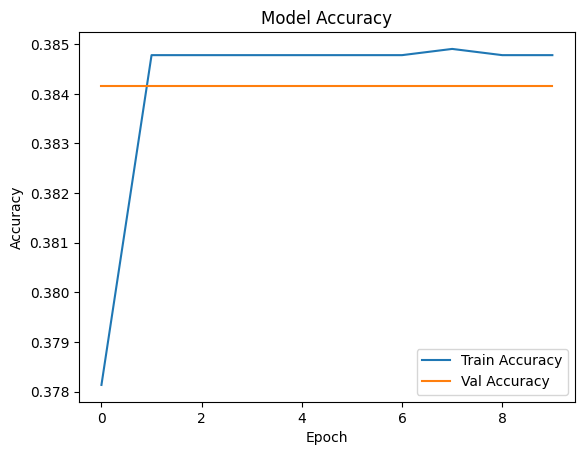

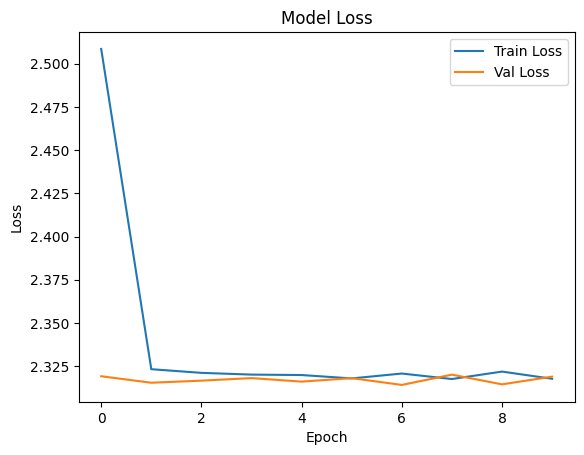

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
                 precision    recall  f1-score   support

          cocoa       0.00      0.00      0.00         6
          grain       0.00      0.00      0.00        45
        veg-oil       0.00      0.00      0.00         8
           earn       0.39      1.00      0.56       384
            acq       0.00      0.00      0.00       221
          wheat       0.00      0.00      0.00         2
         copper       0.00      0.00      0.00         6
        housing       0.00      0.00      0.00         1
   money-supply       0.00      0.00      0.00        14
         coffee       0.00      0.00      0.00        10
          sugar       0.00      0.00      0.00        14
          trade       0.00      0.00      0.00        33
       reserves       0.00      0.00      0.00         5
           ship       0.00      0.00      0.00        19
         cotton       0.00      0.00      0.00         3
        carcass       0.00      0.00      0.00 

/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

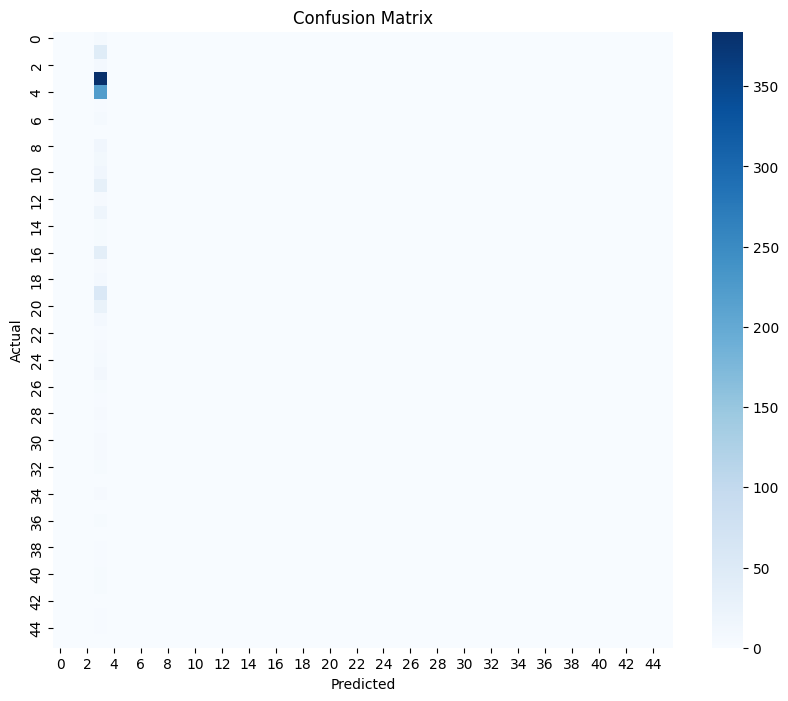

In [61]:
evaluate_model(baseline_model, baseline_history, x_test_padded, y_test_cat)

## Optimized Model

Epoch 1/20


/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


499/499 - 12s - 24ms/step - accuracy: 0.5975 - loss: 0.3871 - val_accuracy: 0.6650 - val_loss: 0.3040 - learning_rate: 1.0000e-03
Epoch 2/20
499/499 - 10s - 19ms/step - accuracy: 0.6928 - loss: 0.2777 - val_accuracy: 0.7141 - val_loss: 0.2590 - learning_rate: 1.0000e-03
Epoch 3/20
499/499 - 10s - 19ms/step - accuracy: 0.7559 - loss: 0.2182 - val_accuracy: 0.7452 - val_loss: 0.2329 - learning_rate: 1.0000e-03
Epoch 4/20
499/499 - 10s - 19ms/step - accuracy: 0.7971 - loss: 0.1771 - val_accuracy: 0.7553 - val_loss: 0.2138 - learning_rate: 1.0000e-03
Epoch 5/20
499/499 - 10s - 19ms/step - accuracy: 0.8217 - loss: 0.1507 - val_accuracy: 0.7733 - val_loss: 0.2109 - learning_rate: 1.0000e-03
Epoch 6/20
499/499 - 10s - 19ms/step - accuracy: 0.8434 - loss: 0.1261 - val_accuracy: 0.7854 - val_loss: 0.2019 - learning_rate: 1.0000e-03
Epoch 7/20
499/499 - 10s - 19ms/step - accuracy: 0.8706 - loss: 0.1055 - val_accuracy: 0.7783 - val_loss: 0.2081 - learning_rate: 1.0000e-03
Epoch 8/20

Epoch 8: Red

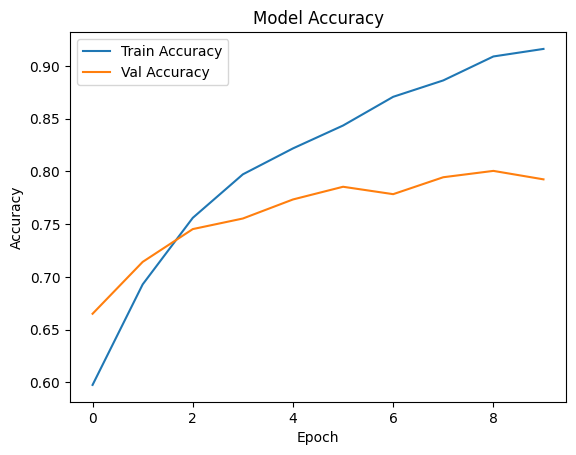

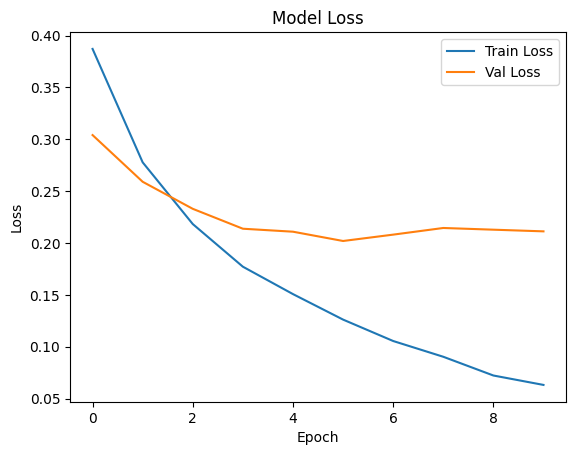

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
                 precision    recall  f1-score   support

          cocoa       0.60      0.50      0.55         6
          grain       0.72      0.87      0.79        45
        veg-oil       1.00      0.75      0.86         8
           earn       0.89      0.94      0.92       384
            acq       0.84      0.87      0.85       221
          wheat       0.00      0.00      0.00         2
         copper       0.50      0.50      0.50         6
        housing       0.00      0.00      0.00         1
   money-supply       0.73      0.57      0.64        14
         coffee       0.90      0.90      0.90        10
          sugar       0.69      0.79      0.73        14
          trade       0.55      0.67      0.60        33
       reserves       0.00      0.00      0.00         5
           ship       0.56      0.53      0.54        19
         cotton       0.00      0.00      0.00         3
        carcass       0.00      0.00      0.00 

/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/sagemaker-user/csc-6621-final-project/.conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

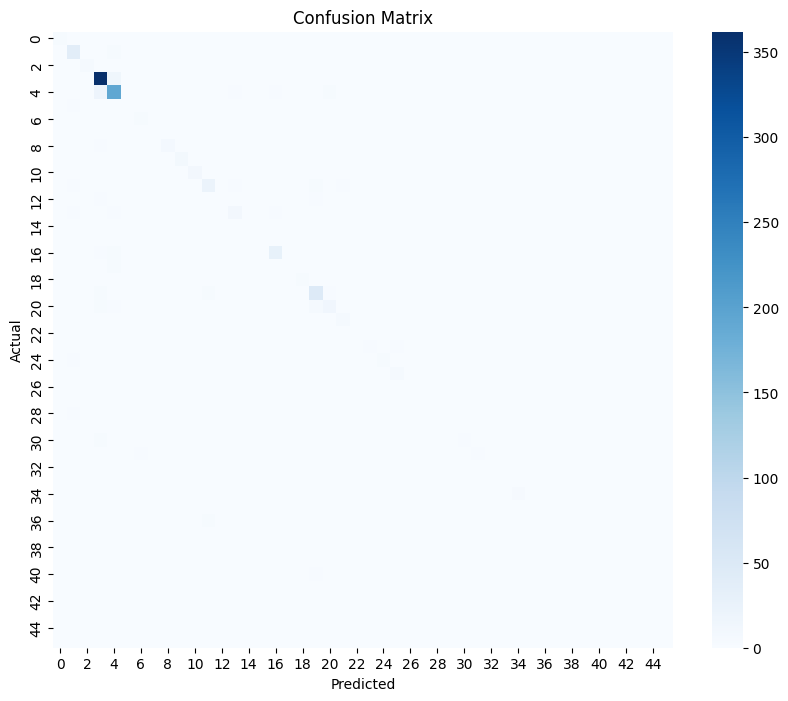

In [62]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=4,
    restore_best_weights=True
)

model = Sequential([
    Embedding(
        input_dim=vocabulary_size,
        output_dim=256,
        input_length=max_sequence_length
    ),
    Bidirectional(LSTM(
        units=64,
        return_sequences=False,
        dropout=0.1
    )),
    Dense(
        units=64,
        activation='relu',
        kernel_regularizer=l2(0.0001)
    ),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=AdamW(),
    loss=CategoricalFocalCrossentropy(gamma=1.5),
    metrics=['accuracy']
)

history = model.fit(
    x_train_padded, y_train_cat,
    validation_data=(x_val_padded, y_val_cat),
    epochs=20,
    batch_size=16,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

evaluate_model(model, history, x_test_padded, y_test_cat)

In [63]:
# glove_zip = "glove.6B.zip"
# glove_url = "http://nlp.stanford.edu/data/glove.6B.zip"

# if not os.path.exists("glove.6B.100d.txt"):
#     if not os.path.exists(glove_zip):
#         print("Downloading GloVe embeddings...")
#         urllib.request.urlretrieve(glove_url, glove_zip)

#     print("Extracting GloVe embeddings...")
#     with zipfile.ZipFile(glove_zip, "r") as zip_ref:
#         zip_ref.extract("glove.6B.100d.txt")


In [64]:
# embeddings_index = {}
# embedding_dim = 100
# with open("glove.6B.100d.txt", "r", encoding="utf-8") as f:
#     for line in f:
#         values = line.split()
#         word = values[0]
#         vector = np.asarray(values[1:], dtype="float32")
#         embeddings_index[word] = vector

# embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

# for word, i in index_by_word.items():
#     if i < vocabulary_size:
#         embedding_vector = embeddings_index.get(word)
#         if embedding_vector is not None:
#             embedding_matrix[i] = embedding_vector



# model = Sequential(
#     [
#         Embedding(
#             input_dim=vocabulary_size,  # Vocabulary size (num_words from word_index)
#             output_dim=embedding_dim,  # GloVe embedding dimensionality (100)
#             weights=[embedding_matrix],  # Use the pre-trained GloVe embeddings
#             input_length=x_train_padded.shape[
#                 1
#             ],  # Length of input sequences (padded sequences length)
#             trainable=True,  # Freeze the embeddings (set True to allow fine-tuning)
#         ),
#     Bidirectional(LSTM(
#         units=32,
#         return_sequences=False,
#         dropout=0.1
#     )),
#     Dense(
#         units=64,
#         activation='relu',
#         kernel_regularizer=l2(0.0001)
#     ),
#     Dropout(0.4),
#     Dense(num_classes, activation='softmax')
# ])

# model.compile(
#     optimizer=AdamW(),
#     loss=CategoricalFocalCrossentropy(gamma=1.5),
#     metrics=['accuracy']
# )

# history = model.fit(
#     x_train_padded, y_train_cat,
#     validation_data=(x_val_padded, y_val_cat),
#     epochs=20,
#     batch_size=16,
#     callbacks=[early_stopping, reduce_lr],
#     verbose=2
# )

# evaluate_model(model, history, x_test_padded, y_test_cat)